In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..")))

import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import community
from sklearn import cluster
from analysis.analysis_utils import FeatureExtractor
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from IPython.core.interactiveshell import InteractiveShell
from analysis import sig_proc

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def entropy(*X):
    """
    Calculate the entropy of a variable, or joint entropy of several variables.
    Parameters
    ----------
    X : array, or list of arrays
        Variable or variables to compute entropy/joint entropy on
    Notes
    -----
    This function can be used to calculate the entropy of a single variable
    (provided as a single input) or to calculate the joint entropy between two
    variables (provided as a series of inputs)
    """
    n_instances = len(X[0])
    H = 0
    for classes in itertools.product(*[set(x) for x in X]):
        v = np.array([True] * n_instances)
        for predictions, c in zip(X, classes):
            v = np.logical_and(v, predictions == c)
        p = np.mean(v)
        H += -p * np.log2(p) if p > 0 else 0
    return H


def conditional_entropy(x, y):
    """
    The conditional entropy H(X|Y) = H(Y,X) - H(Y). X conditioned on Y
    """
    H_y = entropy(y)
    H_yx = entropy(y, x)
    return H_yx - H_y


def mutual_information(x, y):
    """
    The mutual information between two variables
    MI(X, Y) = H(X) + H(Y) - H(X | Y)
    Parameters
    ----------
    x, y : array
    Returns
    -------
    array : mutual information between x and y
    """
    H_x = entropy(x)
    H_y = entropy(y)
    H_xy = entropy(x, y)
    return H_x + H_y - H_xy


def entropy_cc(x, y):
    """
    The entropy correlation coefficient:
    p(H) = sqrt(MI(X, Y) / 0.5 * (H(X) + H(Y)))
    """
    H_x = entropy(x)
    H_y = entropy(y)
    I_xy = mutual_information(y, x)
    return np.sqrt(I_xy / (0.5 * (H_x + H_y)))


def transfer_entropy(x, y, lag=1):
    """
    Transfer entropy for two given signals.
    Parameters
    ----------
      x : array
        source
      y : array
        target
      lag : int
    Returns
    -------
    array : Transfer entropy from x to y
    """
    # Future of i
    Fi = np.roll(x, -lag)
    # Past of i
    Pi = x
    # Past of j
    Pj = y

    # Transfer entropy
    Inf_from_Pi_to_Fi = conditional_entropy(Fi, Pi)

    # Same as cond_entropy(Fi, Pi_Pj)
    H_y = entropy(Pi, Pj)
    H_yx = entropy(Fi, Pj, Pi)
    Inf_from_Pi_Pj_to_Fi = H_yx - H_y

    TE_from_j_to_i = Inf_from_Pi_to_Fi - Inf_from_Pi_Pj_to_Fi

    return TE_from_j_to_i

In [4]:
def find_files(directory, filetype):

    if not os.path.exists(directory):
        print("{} does not exist".format(directory), file=sys.stderr)

    file_num = 0
    raw_files = list()
    for dir_name, subdir_list, file_list in os.walk(mouse_directory):
        for file_name in file_list:
            if file_name.endswith(filetype):
                print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
                file_num += 1
                raw_files.append(os.path.join(dir_name, file_name))
                
    return raw_files

In [5]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")
raw_files = find_files(mouse_directory, ".csv")

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: DRD87_EPM_NEW_BEH.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/DRD87_EPM_NEW_BEH.csv
2. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
3. full path of: Drd87_EPM_C_thresh.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Drd87_EPM_C_thresh.csv
4. full path of: DRD87_EPM_NEW_BEH_COL.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/DRD87_EPM_NEW_BEH_COL.csv
5. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM2_drd87.csv
6. full path of: Drd87_EPM_S_thresh.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Drd87_EPM_S_thresh.csv
7. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
8. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
9. full path of: Raw_EPM_drd77.c

In [6]:
# raw_data = pd.read_csv(raw_files[2], header=None)
# deconvoluter = Deconvoluter(raw_data)

behaviors = ['Trial_time',
             'Recording_time',
             'X_center',
             'Y_center',
             'Area',
             'Areachange',
             'Elongation',
             'Distance_moved',
             'Velocity',
             'Arena_centerpoint',
             'Open1_centerpoint',
             'Open2_centerpoint',
             'Closed1_centerpoint',
             'Closed2_centerpoint',
             'OpenArms_centerpoint',
             'ClosedArms_centerpoint',
             'Hardware_command',
             'Hardware_command_2',
             'Hardware_command_3',
             'Hardware_command_4',
             'Result_1',
             'Head_Dips']

behavior_df = pd.read_csv(raw_files[1], header=None)
beh_cols = pd.read_csv(raw_files[4], header=None)
S = pd.read_csv(raw_files[6], header=None)
C = pd.read_csv(raw_files[3], header=None)
drd87 = FeatureExtractor(cell_transients_df=C, auc_df=S, behavior_df=behavior_df, behavior_col_names=behaviors)

# Reindex neuron column vectors from 0, 1, 2, ..., n --> 1, 2, 3, ..., n, n+1
drd87.cell_transients_df.columns = [col+1 for col in drd87.cell_transients_df.columns]
drd87.auc_df.columns = [col+1 for col in drd87.auc_df.columns]

# Drop useless columns
drd87.neuron_concated_behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd87.auc_df = drd87.auc_df.where(drd87.auc_df == 0, 1)

# Add "Center" column to concatenated dataframe
center = (drd87.neuron_concated_behavior["OpenArms_centerpoint"]) + (drd87.neuron_concated_behavior["ClosedArms_centerpoint"])
center = 1-center
drd87.neuron_concated_behavior["Center"] = center

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:29: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [ ]:
drd77_raw_data = pd.read_csv(raw_files[5], header=None)
drd77_raw_data = FeatureExtractor.downsample_dataframe(drd77_raw_data, 2)
deconvoluter = Deconvoluter(drd77_raw_data)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[6], header=None)
drd77 = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Reindex the neuron column vectors from 0, 1, 2, ... n --> 1, 2, 3, ..., n, n+1
drd77.auc_df.columns = [col+1 for col in drd77.auc_df]
drd77.cell_transients_df.columns = [col+1 for col in drd77.cell_transients_df]

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd77.auc_df = drd77.auc_df.where(drd77.auc_df == 0, 1)

# Add "Center" column to concatenated dataframe
center = (drd77.neuron_concated_behavior["OpenArms_centerpoint"]) + (drd77.neuron_concated_behavior["ClosedArms_centerpoint"])
center = 1-center
drd77.neuron_concated_behavior["Center"] = center

In [ ]:
drd73_raw_data = pd.read_csv(raw_files[3], header=None)
drd73_raw_data = FeatureExtractor.downsample_dataframe(drd73_raw_data, 2)
deconvoluter = Deconvoluter(drd73_raw_data)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[4], header=None)
drd73 = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Only leave the neuron numbers to save space when plotting the networks
drd73.auc_df.columns = [col+1 for col in drd73.auc_df.columns]
drd73.cell_transients_df.columns = [col+1 for col in drd73.cell_transients_df.columns]

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd73.auc_df = drd73.auc_df.where(drd73.auc_df == 0, 1)

# Add "Center" column to concatenated dataframe
center = (drd73.neuron_concated_behavior["OpenArms_centerpoint"]) + (drd73.neuron_concated_behavior["ClosedArms_centerpoint"])
center = 1-center
drd73.neuron_concated_behavior["Center"] = center

In [ ]:
drd46_raw_data = pd.read_csv(raw_files[8], header=None)
deconvoluter = Deconvoluter(drd46_raw_data)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[7], header=None)
drd46 = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Only leave the neuron numbers to save space when plotting the networks
drd46.auc_df.columns = [col+1 for col in drd46.auc_df.columns]

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd46.auc_df = drd46.auc_df.where(drd46.auc_df == 0, 1)

In [7]:
def get_continuous_beh_indices(mouse, behavior, **kwargs):
    num_of_sec = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)
    indices = []
    continuous_beh = {}
    
    for row in mouse.neuron_concated_behavior.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= 1: # num_of_sec*framerate:
                
                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]
                indices.append((begin, end))

            continuous_beh.clear()
                
    return indices

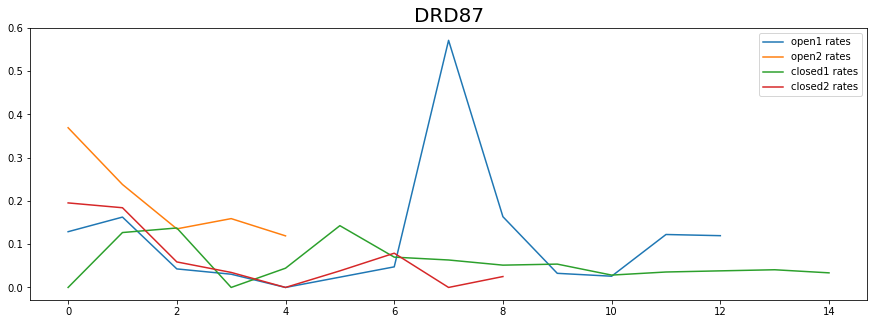

In [8]:
open1_cont_beh_indices = get_continuous_beh_indices(drd87, "Open1_centerpoint", seconds=2)
open2_cont_beh_indices = get_continuous_beh_indices(drd87, "Open2_centerpoint", seconds=2)
closed1_cont_beh_indices = get_continuous_beh_indices(drd87, "Closed1_centerpoint", seconds=2)
closed2_cont_beh_indices = get_continuous_beh_indices(drd87, "Closed2_centerpoint", seconds=2)

open1_rates = []
open2_rates = []
closed1_rates = []
closed2_rates = []

for index_tuple in open1_cont_beh_indices:
    open1_rates.append(10 * drd87.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in open2_cont_beh_indices:
    open2_rates.append(10 * drd87.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed1_cont_beh_indices:
    closed1_rates.append(10 * drd87.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed2_cont_beh_indices:
    closed2_rates.append(10 * drd87.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
plt.figure(figsize=(15, 5))
plt.title("DRD87", fontsize=20)
plt.plot(open1_rates)
plt.plot(open2_rates)
plt.plot(closed1_rates)
plt.plot(closed2_rates)
plt.legend(["open1 rates", "open2 rates", "closed1 rates", "closed2 rates"], loc="upper right")
plt.show();

In [ ]:
open1_cont_beh_indices = get_continuous_beh_indices(drd77, "Open1_centerpoint", seconds=2)
open2_cont_beh_indices = get_continuous_beh_indices(drd77, "Open2_centerpoint", seconds=2)
closed1_cont_beh_indices = get_continuous_beh_indices(drd77, "Closed1_centerpoint", seconds=2)
closed2_cont_beh_indices = get_continuous_beh_indices(drd77, "Closed2_centerpoint", seconds=2)

open1_rates = []
open2_rates = []
closed1_rates = []
closed2_rates = []

for index_tuple in open1_cont_beh_indices:
    open1_rates.append(10 * drd77.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in open2_cont_beh_indices:
    open2_rates.append(10 * drd77.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed1_cont_beh_indices:
    closed1_rates.append(10 * drd77.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed2_cont_beh_indices:
    closed2_rates.append(10 * drd77.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
plt.figure(figsize=(15, 5))
plt.title("DRD77", fontsize=20)
plt.plot(open1_rates)
plt.plot(open2_rates)
plt.plot(closed1_rates)
plt.plot(closed2_rates)
plt.legend(["open1 rates", "open2 rates", "closed1 rates", "closed2 rates"], loc="upper right")
plt.show();

In [ ]:
open1_cont_beh_indices = get_continuous_beh_indices(drd73, "Open1_centerpoint", seconds=2)
open2_cont_beh_indices = get_continuous_beh_indices(drd73, "Open2_centerpoint", seconds=2)
closed1_cont_beh_indices = get_continuous_beh_indices(drd73, "Closed1_centerpoint", seconds=2)
closed2_cont_beh_indices = get_continuous_beh_indices(drd73, "Closed2_centerpoint", seconds=2)

open1_rates = []
open2_rates = []
closed1_rates = []
closed2_rates = []

for index_tuple in open1_cont_beh_indices:
    open1_rates.append(10 * drd73.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in open2_cont_beh_indices:
    open2_rates.append(10 * drd73.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed1_cont_beh_indices:
    closed1_rates.append(10 * drd73.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed2_cont_beh_indices:
    closed2_rates.append(10 * drd73.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
plt.figure(figsize=(15, 5))
plt.title("DRD73", fontsize=20)
plt.plot(open1_rates)
plt.plot(open2_rates)
plt.plot(closed1_rates)
plt.plot(closed2_rates)
plt.legend(["open1 rates", "open2 rates", "closed1 rates", "closed2 rates"], loc="upper right")
plt.show();

In [ ]:
open1_cont_beh_indices = get_continuous_beh_indices(drd46, "Open1_centerpoint", seconds=2)
open2_cont_beh_indices = get_continuous_beh_indices(drd46, "Open2_centerpoint", seconds=2)
closed1_cont_beh_indices = get_continuous_beh_indices(drd46, "Closed1_centerpoint", seconds=2)
closed2_cont_beh_indices = get_continuous_beh_indices(drd46, "Closed2_centerpoint", seconds=2)

open1_rates = []
open2_rates = []
closed1_rates = []
closed2_rates = []

for index_tuple in open1_cont_beh_indices:
    open1_rates.append(10 * drd46.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in open2_cont_beh_indices:
    open2_rates.append(10 * drd46.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed1_cont_beh_indices:
    closed1_rates.append(10 * drd46.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
for index_tuple in closed2_cont_beh_indices:
    closed2_rates.append(10 * drd46.auc_df.iloc[index_tuple[0]:index_tuple[1]+1].mean().mean())
    
plt.figure(figsize=(15, 5))
plt.title("DRD46", fontsize=20)
plt.plot(open1_rates)
plt.plot(open2_rates)
plt.plot(closed1_rates)
plt.plot(closed2_rates)
plt.legend(["open1 rates", "open2 rates", "closed1 rates", "closed2 rates"], loc="upper right")
plt.show();

In [9]:
def compute_nmi(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        H_x = entropy(dataframe[neuron_pair[0]].values)
        H_y = entropy(dataframe[neuron_pair[1]].values)
        if 0.5 * (H_x + H_y) == 0:
            # print("AVOIDED DIV BY ZERO", file=sys.stderr)
            nmi = 0
            connections[neuron_pair] = nmi
        else:
            nmi = entropy_cc(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)
            connections[neuron_pair] = nmi
        
    return connections

def compute_corrcoef(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        if dataframe[neuron_pair[0]].std() == 0 or dataframe[neuron_pair[1]].std() == 0:
            continue

        corrcoef = np.corrcoef(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)[0][1]
        if corrcoef >= 0:
            connections[neuron_pair] = corrcoef
        
    return connections

def nmi_matrix(dataframe):
    nmi_df = pd.DataFrame(columns=dataframe.columns, index=dataframe.columns)
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        H_x = entropy(dataframe[neuron_pair[0]].values)
        H_y = entropy(dataframe[neuron_pair[1]].values)
        if 0.5 * (H_x + H_y) == 0:
            # print("AVOIDED DIV BY ZERO", file=sys.stderr)
            nmi = 0
        else:
            nmi = entropy_cc(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)
        
        nmi_df.iat[neuron_pair[0]-1, neuron_pair[1]-1] = nmi
        nmi_df.iat[neuron_pair[1]-1, neuron_pair[0]-1] = nmi
    
    nmi_df.fillna(0, inplace=True)
    return nmi_df

def plot(graph, node_colors):
    pos = nx.spring_layout(graph, weight="weight")
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    nx.draw_networkx_nodes(graph, pos, node_size=600, cmap=plt.cm.tab20, node_color=node_colors)
    nx.draw_networkx_edges(graph, pos, alpha=0.2)
    nx.draw_networkx_labels(graph, pos, font_size=10)
    plt.show(graph);

In [12]:
def extract_modules(partitions):
    total_modules = len(partitions.values()) - 1 
    modules = {}

    for neuron in partitions:
        if partitions[neuron] not in modules:
            modules[partitions[neuron]] = [neuron]
        else:
            modules[partitions[neuron]].append(neuron)
    
    return modules

def plot_traces(modules, mouse, **kwargs):
    figsize = kwargs.get("figsize", (15, 6))
    hspace = kwargs.get("hspace", 0.0)
    file_name = kwargs.get("file_name", "neural_traces.png")
    total_subplots = 0
    
    for module in modules:
        if len(modules[module]) > 1:
            total_subplots += len(modules[module])
            
    cmap = get_cmap(max(modules.keys())+1, name="Dark2")
    fig, ax = plt.subplots(total_subplots, 1, figsize=figsize)
    
    center_frames = get_continuous_beh_indices(mouse, "Center")
    open_arms_frames = get_continuous_beh_indices(mouse, "OpenArms_centerpoint")
    closed_arms_frames = get_continuous_beh_indices(mouse, "ClosedArms_centerpoint")
    head_dip_frames = get_continuous_beh_indices(mouse, "Head_Dips")
    
    ax_index = 0
    dataframe = mouse.cell_transients_df
    for neurons in modules:
        if len(modules[neurons]) > 1:
            for index in range(0, len(modules[neurons])):
                ax[ax_index].plot(dataframe.index, dataframe[modules[neurons][index]], c=cmap(neurons), lw=2)
                for time_period in open_arms_frames:
                    ax[ax_index].axvspan(time_period[0], time_period[1], alpha=0.1, color="red")
                    ax[ax_index].axis("off")
                for time_period in center_frames:
                    ax[ax_index].axvspan(time_period[0], time_period[1], alpha=0.1, color="orange")
                    ax[ax_index].axis("off")
                for time_period in head_dip_frames:
                    ax[ax_index].axvspan(time_period[0], time_period[1], alpha=0.1, color="grey")
                    ax[ax_index].axis("off")
                for time_period in closed_arms_frames:
                    ax[ax_index].axvspan(time_period[0], time_period[1], alpha=0.1, color="lightcyan")
                    ax[ax_index].axis("off")
                ax_index += 1
            
    plt.subplots_adjust(wspace=0, hspace=hspace)
    plt.savefig(file_name)
    plt.show();
    
def get_cmap(n, name="tab20"):
    """ Returns a function that maps each index in 0, 1, ..., n-1 
        to a distinct RGB color; the keyword argument name must 
        be a standard mpl colormap name.
    """
    return plt.cm.get_cmap(name, n)

#### DRD87 in EPM (overall)

Cluster 0: [3, 5, 6, 9, 12, 15, 20, 26, 28, 32, 37, 43, 47, 54, 58, 63, 64, 65, 67, 68]
Cluster 1: [1, 17, 34, 35, 61]
Cluster 2: [7, 16, 18, 22, 24, 25, 27, 40, 41, 42, 44, 59, 62, 66, 69]
Cluster 3: [19, 33, 38, 48, 60]
Cluster 4: [11, 36, 45, 46, 50]
Cluster 5: [2, 13, 29, 51, 53]
Cluster 6: [4, 23, 31, 49, 52, 55, 70]
Cluster 7: [8, 10, 14, 21, 30, 39, 56, 57]


You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


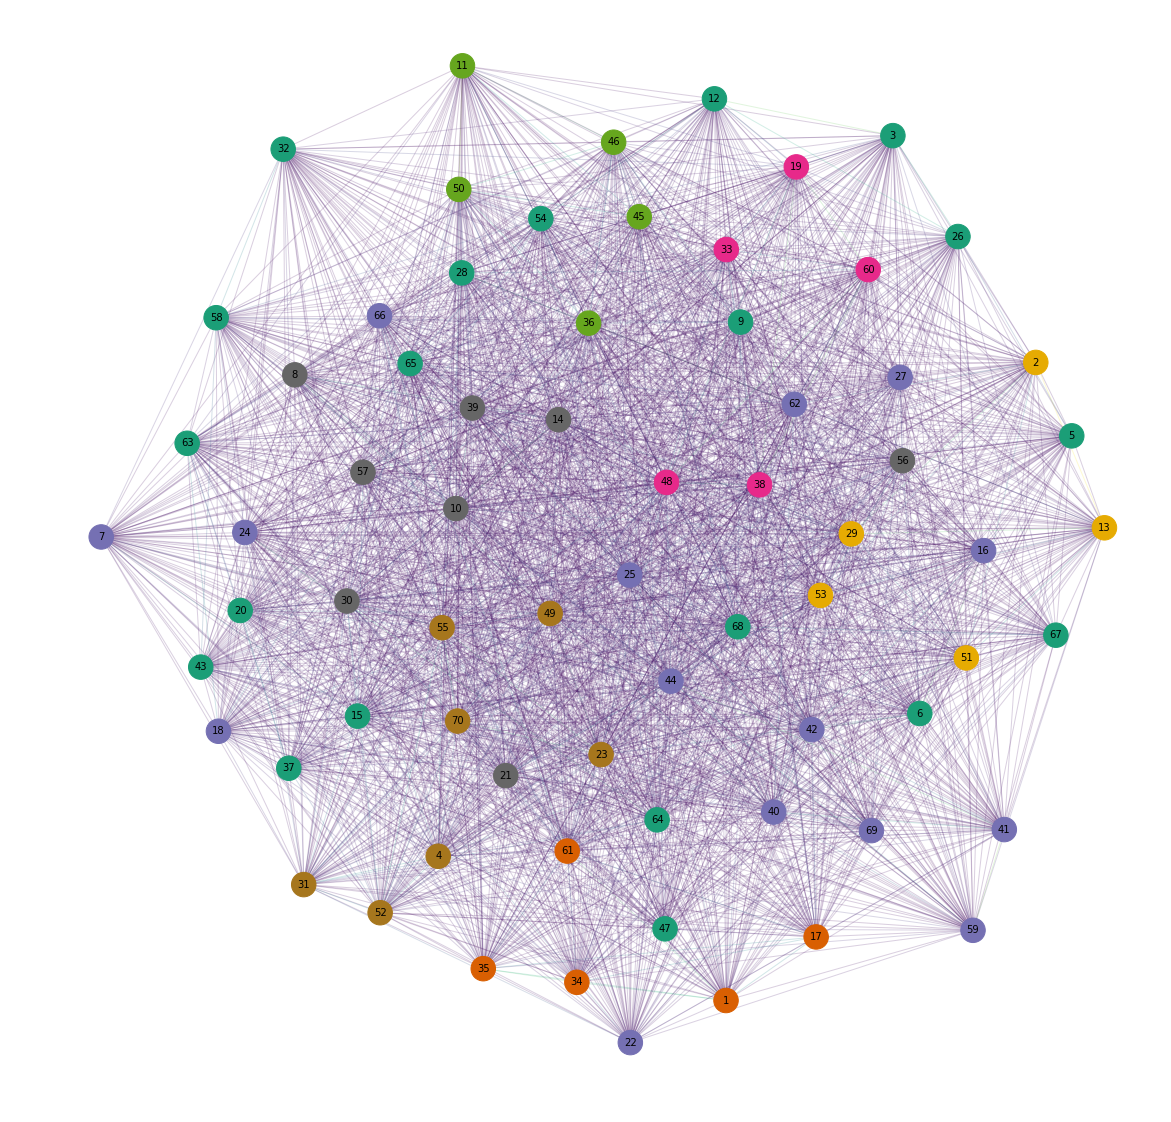

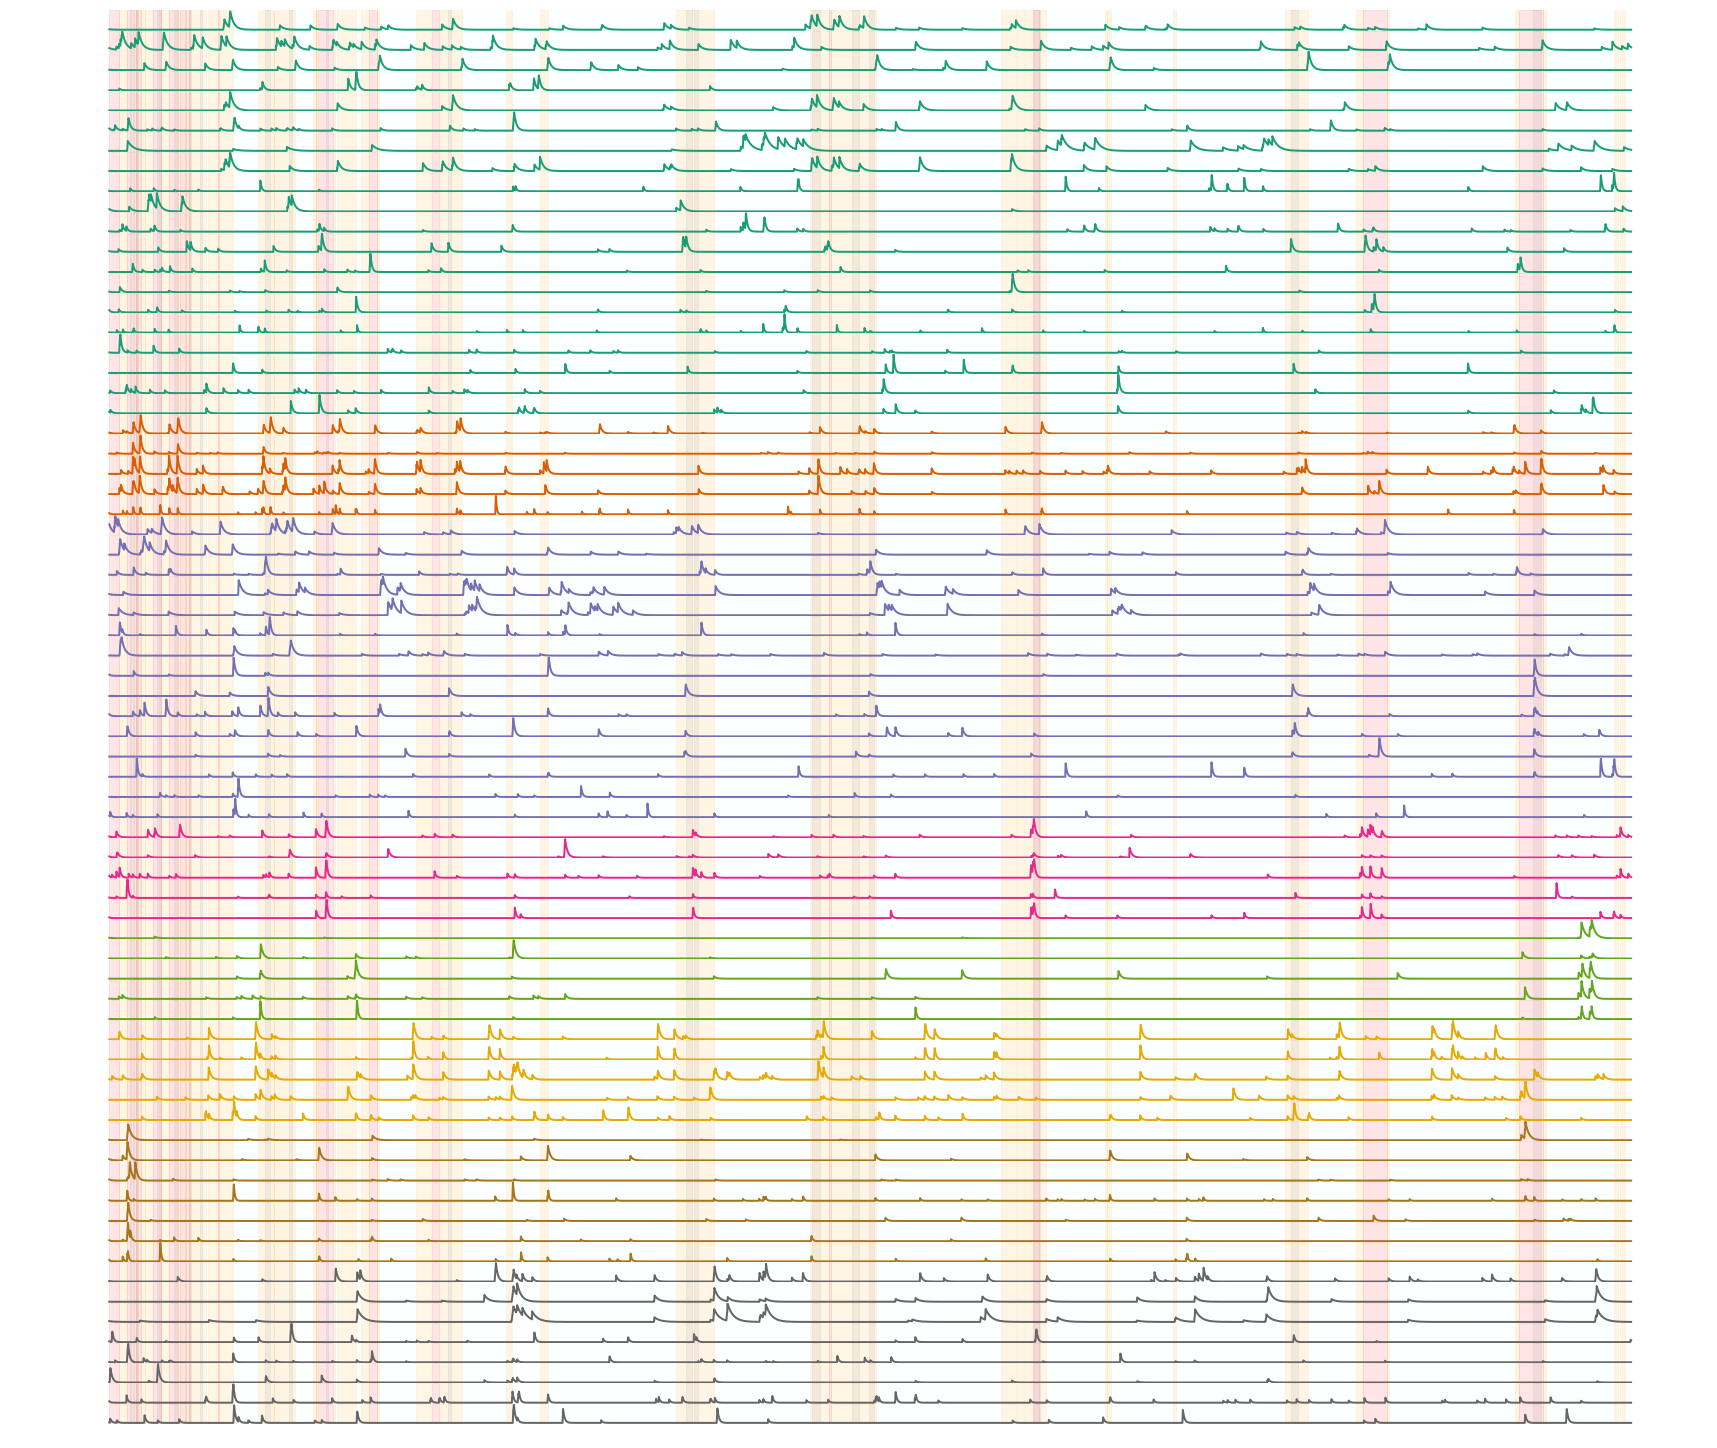

In [13]:
connections = compute_nmi(drd87.auc_df)
drd87_graph = NeuronNetwork(drd87.auc_df.columns, connections)
  
# X = drd87.auc_df.corr().where(drd87.auc_df.corr() >= 0, 0)
X = nmi_matrix(drd87.auc_df)
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd87.auc_df.columns[labels==i])))
    for neuron in list(drd87.auc_df.columns[labels==i]):
        clusters[neuron] = i
        
node_colors = [clusters[key] for key in sorted(clusters.keys())]

drd87_graph.plot(node_colors=node_colors, figsize=(20,20), node_size=600, save=True, file_name="EPM_DRD87_TOTAL.png")

modules = extract_modules(clusters)
plot_traces(modules, drd87, figsize=(30, 26), hspace=0.0, file_name="DRD87_CLUSTER_TRACES_OVERALL.png")

#### DRD87 in EPM (Closed Arms)

In [ ]:
indices = drd87.neuron_concated_behavior.loc[drd87.neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
connections = compute_nmi(drd87.auc_df.iloc[indices])
drd87_graph = NeuronNetwork(drd87.auc_df.columns, connections)
 
# X = drd87.auc_df.iloc[indices].corr().where(drd87.auc_df.iloc[indices].corr() >= 0, 0)
X = nmi_matrix(drd87.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd87.auc_df.columns[labels == i])))
    for neuron in list(drd87.auc_df.columns[labels == i]):
        clusters[neuron] = i
        
node_colors = [clusters[key] for key in sorted(clusters.keys())]
drd87_graph.plot(node_colors=node_colors, figsize=(20,20), node_size=600, save=True, file_name="EPM_DRD87_CLOSED.png")

modules = extract_modules(clusters)
plot_traces(modules, drd87.cell_transients_df, drd87, figsize=(30, 26), hspace=0.0, file_name="DRD87_CLUSTER_TRACES_CLOSED.png")

#### DRD87 in EPM (open arms)

In [ ]:
indices = drd87.neuron_concated_behavior.loc[drd87.neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
connections = compute_nmi(drd87.auc_df.iloc[indices])
drd87_graph = NeuronNetwork(drd87.auc_df.columns, connections)

# X = drd87.auc_df.iloc[indices].corr().where(drd87.auc_df.iloc[indices].corr() >= 0, 0)
X = nmi_matrix(drd87.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd87.auc_df.columns[labels == i])))
    for neuron in list(drd87.auc_df.columns[labels == i]):
        clusters[neuron] = i

node_colors = [clusters[key] for key in sorted(clusters.keys())]

drd87_graph.plot(node_colors=node_colors, figsize=(30,30), node_size=600, save=True, file_name="EPM_DRD87_OPEN.png")

modules = extract_modules(clusters)
plot_traces(modules, drd87.cell_transients_df, drd87, figsize=(30, 26), hspace=0.0, file_name="DRD87_CLUSTER_TRACES_OPEN.png")

#### DRD87 in EPM (center)

In [ ]:
indices = drd87.neuron_concated_behavior.loc[drd87.neuron_concated_behavior["Center"] != 0].index
connections = compute_nmi(drd87.auc_df.iloc[indices])
drd87_graph = NeuronNetwork(drd87.auc_df.columns, connections)

# X = drd87.auc_df.iloc[indices].corr().where(drd87.auc_df.iloc[indices].corr() >= 0, 0)
X = nmi_matrix(drd87.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd87.auc_df.columns[labels == i])))
    for neuron in list(drd87.auc_df.columns[labels == i]):
        clusters[neuron] = i

node_colors = [clusters[key] for key in sorted(clusters.keys())]

drd87_graph.plot(node_colors=node_colors, figsize=(30,30), node_size=600, save=True, file_name="EPM_DRD87_CENTER.png")

modules = extract_modules(clusters)
plot_traces(modules, drd87.cell_transients_df, drd87, figsize=(30, 26), hspace=0.0, file_name="DRD87_CLUSTER_TRACES_CENTER.png")

#### DRD77 (overall)

In [ ]:
connections = compute_nmi(drd77.auc_df)
drd77_graph = NeuronNetwork(drd77.auc_df.columns, connections)

# X = drd77.auc_df.corr().where(drd77.auc_df.corr() >= 0, 0)
X = nmi_matrix(drd77.auc_df)
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd77.auc_df.columns[labels == i])))
    for neuron in list(drd77.auc_df.columns[labels == i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd77_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD77_TOTAL.png")

modules = extract_modules(clusters)
plot_traces(modules, drd77.cell_transients_df, drd77, figsize=(20, 16), hspace=-0.0)

#### DRD77 in EPM (closed arms)

In [ ]:
indices = drd77.neuron_concated_behavior.loc[drd77.neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
connections = compute_nmi(drd77.auc_df.iloc[indices])
drd77_graph = NeuronNetwork(drd77.auc_df.columns, connections)

# X = drd77.auc_df.iloc[indices].corr().where(drd77.auc_df.iloc[indices].corr() >= 0, 0)
X = nmi_matrix(drd77.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd77.auc_df.columns[labels == i])))
    for neuron in list(drd77.auc_df.columns[labels == i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd77_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD77_CLOSED.png")

modules = extract_modules(clusters)
plot_traces(modules, drd77.cell_transients_df, drd77, figsize=(18, 10), hspace=-0.3)

#### DRD77 in EPM (open arms)

In [ ]:
indices = drd77.neuron_concated_behavior.loc[drd77.neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
connections = compute_nmi(drd77.auc_df.iloc[indices])
drd77_graph = NeuronNetwork(drd77.auc_df.columns, connections)

# X = drd77.auc_df.iloc[indices].corr().where(drd77.auc_df.iloc[indices].corr() >= 0, 0)
X = nmi_matrix(drd77.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd77.auc_df.columns[labels == i])))
    for neuron in list(drd77.auc_df.columns[labels == i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd77_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD77_OPEN.png")

modules = extract_modules(clusters)
plot_traces(modules, drd77.cell_transients_df, drd77, figsize=(18, 10), hspace=-0.3)

#### DRD77 in EPM (center)

In [ ]:
indices = drd77.neuron_concated_behavior.loc[drd77.neuron_concated_behavior["Center"] != 0].index
connections = compute_nmi(drd77.auc_df.iloc[indices])
drd77_graph = NeuronNetwork(drd77.auc_df.columns, connections)

# X = drd77.auc_df.iloc[indices].corr().where(drd77.auc_df.iloc[indices].corr() >= 0, 0)
X = nmi_matrix(drd77.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd77.auc_df.columns[labels == i])))
    for neuron in list(drd77.auc_df.columns[labels == i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd77_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD77_OPEN.png")

modules = extract_modules(clusters)
plot_traces(modules, drd77.cell_transients_df, drd77, figsize=(18, 10), hspace=-0.3)

#### DRD73 in EPM (overall)

In [ ]:
connections = compute_nmi(drd73.auc_df)
drd73_graph = NeuronNetwork(drd73.auc_df.columns, connections)

X = nmi_matrix(drd73.auc_df)
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd73.auc_df.columns[labels==i])))
    for neuron in list(drd73.auc_df.columns[labels == i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd73_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD73_TOTAL.png")

modules = extract_modules(clusters)
plot_traces(modules, drd73.cell_transients_df, drd73, figsize=(18, 10), hspace=-0.0)

#### DRD73 in EPM (closed arms)

In [ ]:
indices = drd73.neuron_concated_behavior.loc[drd73.neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
connections = compute_nmi(drd73.auc_df.iloc[indices])
drd73_graph = NeuronNetwork(drd73.auc_df.columns, connections)

X = nmi_matrix(drd73.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd73.auc_df.columns[labels==i])))
    for neuron in list(drd73.auc_df.columns[labels==i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd73_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD73_CLOSED.png")

modules = extract_modules(clusters)
plot_traces(modules, drd73.cell_transients_df, drd73, figsize=(18, 10), hspace=-0.0)

#### DRD73 in EPM (open arms)

In [ ]:
indices = drd73.neuron_concated_behavior.loc[drd73.neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
connections = compute_nmi(drd73.auc_df.iloc[indices])
drd73_graph = NeuronNetwork(drd73.auc_df.columns, connections)

X = nmi_matrix(drd73.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd73.auc_df.columns[labels==i])))
    for neuron in list(drd73.auc_df.columns[labels==i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd73_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD73_OPEN.png")

modules = extract_modules(clusters)
plot_traces(modules, drd73.cell_transients_df, drd73, figsize=(18, 10), hspace=-0.0)

#### DRD73 in EPM (center)

In [ ]:
indices = drd73.neuron_concated_behavior.loc[drd73.neuron_concated_behavior["Center"] != 0].index
connections = compute_nmi(drd73.auc_df.iloc[indices])
drd73_graph = NeuronNetwork(drd73.auc_df.columns, connections)

X = nmi_matrix(drd73.auc_df.iloc[indices])
labels = cluster.AffinityPropagation().fit_predict(X)
n_labels = labels.max()

clusters = {}
for i in range(n_labels+1):
    print("Cluster {}: {}".format(i, list(drd73.auc_df.columns[labels==i])))
    for neuron in list(drd73.auc_df.columns[labels==i]):
        clusters[neuron] = i
        
node_colors = []
for key in sorted(clusters.keys()):
    node_colors.append(clusters[key])

drd73_graph.plot(node_colors=node_colors, figsize=(15,15), node_size=600, save=True, file_name="EPM_DRD73_OPEN.png")

modules = extract_modules(clusters)
plot_traces(modules, drd73.cell_transients_df, drd73, figsize=(18, 10), hspace=-0.0)

### Behavior & States

### [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) between neurons and behavior

In [ ]:
from multiprocessing import Process
from multiprocessing import Queue

def _permutation_resample(queue, dataframe, beh_col_vec, resamples):
    rows_list = []

    for _ in range(resamples):
        resampled_beh_col_vec = beh_col_vec.sample(frac=1).reset_index(drop=True)
        row = dict(dataframe.apply(entropy_cc, args=(resampled_beh_col_vec,)))
        rows_list.append(row)
        
    queue.put(pd.DataFrame(rows_list))

def permutation_resample(dataframe, beh_col_vec, resamples):
    resamples_per_worker = resamples // os.cpu_count()
    queue = Queue()
    processes = []
    rets = []
    for _ in range(os.cpu_count()):
        process = Process(target=_permutation_resample, args=(queue, dataframe, beh_col_vec, resamples_per_worker))
        processes.append(process)
        process.start()
    for process in processes:
        ret = queue.get()  # will block
        rets.append(ret)
    for process in processes:
        process.join()

    return pd.concat(rets, ignore_index=True)

def one_side_p_val(resampled_df, resamples, neuron, actual_val):
    return (1/resamples) * len(resampled_df[neuron].loc[resampled_df[neuron] >= actual_val])

In [ ]:
drd87_nmi_scores = dict(drd87.auc_df.apply(entropy_cc, args=(drd87.neuron_concated_behavior["OpenArms_centerpoint"],)))
resampled_df = permutation_resample(drd87.auc_df, drd87.neuron_concated_behavior["OpenArms_centerpoint"], 10000)

In [ ]:
for neuron in drd87.auc_df.columns:
    p_val = one_side_p_val(resampled_df, 10000, neuron, drd87_nmi_scores[neuron])
    if p_val < 0.05:
        print("{}: {}".format(neuron, p_val))

In [ ]:
drd87_nmi_scores = dict(drd87.auc_df.apply(entropy_cc, args=(drd87.neuron_concated_behavior["OpenArms_centerpoint"],)))
resampled_df = permutation_resample(drd87.auc_df, drd87.neuron_concated_behavior["OpenArms_centerpoint"], 10000)

In [ ]:
for neuron in drd87.auc_df.columns:
    p_val = one_side_p_val(resampled_df, 10000, neuron, drd87_nmi_scores[neuron])
    if p_val < 0.05:
        print("{}: {}".format(neuron, p_val))